# ER131 Final Project (replace this with your project title)
Fall 2020

In this cell, give an alphabetical (by last name) list of student group members.  Beside each student's name, provide a description of each student's contribution to the project.

**Longmate, Julia**: [contribution] <br>
**Murayama, Hikari**: [contribution] <br>
**Sims, Michelle**: [contribution] <br>
**Worsham, Marshall**: [contribution] <br>

## Basic Project Requirements (delete this markdown cell in your final submission)

**How to use this notebook**:  This notebook is the template for your semester project.  Each markdown cell provides instructions on what to do in order to complete a successful project.  The cell you're reading right now is the only one you can delete from what you eventually hand in.  For the other cells:
1. You may replace the instructions in each cell with your own work but do not edit the cell titles (with the exception of the project title, above).  
2. Follow the instructions in each section carefully.  For some sections you will enter only markdown text in the existing cells. For other sections, you'll accompany the markdown cells with additional code cells, and perhaps more markdown, before moving on to the next section.  

**Grading**.  You'll see point allocations listed in each of the section titles below.  In addition, there are other categories for points: 
1. Visualization (10 points).  Plots should be well organized, legible, labelled, and well-suited for the question they are being used to answer or explore.  
2. Clarity (5 points). Note that clarity also supports points elsewhere, because if we can't understand what you're explaining, we'll assume you didn't understand what you were doing and give points accordingly!  

For each Section or Category, we will give points according to the following percentage scale:
1. More than 90%:  work that is free of anything but superficial mistakes, and demonstrates creativity and / or a very deep understanding of what you are doing.
2. 80-90%: work without fundamental errors and demonstrates a basic understanding of what you're doing.
3. 60-80%: work with fundamental flaws in the analysis and / or conveys that you do not understand the basics of the work you are trying to do.
4. Below 60%: Work that is severely lacking or incomplete.  

Note that we distinguish *mistakes* from *"my idea didn't work"*.  Sometimes you don't know if you can actually do the thing you're trying to do and as you dig in you find that you can't.  That doesn't necessarily mean you made a mistake; it might just mean you needed more information.  We'll still give high marks to ambitious projects that "fail" at their stated objective, as long as that objective was clear and you demonstrate an understanding of what you were doing and why it didn't work.

**Number of prediction questions:**  The number of prediction questions must be greater than or equal to the number of students in the team minus one.  (A 4 person team would need to explore 4-1 = 3 questions.)  Questions should be related, but have distinct work efforts, interpretation and analysis. An example: for land use regression, you could have a core prediction question (what is pollution concentration on a fine spatial scale), a supporting question that explore how the degree of spatial aggregation influences prediction quality, plus a prediction model that explores *temporal* prediction at one point in space.  There is a lot of flexibility here; if you have any doubt about whether your questions are distinct, consult with the instructors.

**Data requirements**:  Projects must use data from a minimum of $1+N_s$ different sources, where $N_s$ is the number of students in the group.  You should merge at least two data sets. </font>

**Advice on Project Topics**:  We want you to do a project that relates to energy and environment topics.  

**Suggested data sets**: If you choose not to work on a client projets, here are some ideas for data starting points. You can definitely bring your own data to the table!
1. [Purple Air](https://www.purpleair.com) Instructions on how to download PurpleAir data are [here](https://docs.google.com/document/d/15ijz94dXJ-YAZLi9iZ_RaBwrZ4KtYeCy08goGBwnbCU/edit).
2. California Enviroscreen database.  Available [here].(https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30) 
3. Several data sets available from the UC Irvine machine learning library:
    1. [Forest Fires](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)
    4. [Climate](https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network)
    5. [Ozone](https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection)
4. California Solar Initiative data (installed rooftop solar systems).  Available [here](https://www.californiasolarstatistics.ca.gov/data_downloads/).
5. World Bank Open Data, available [here](https://data.worldbank.org).
6. California ISO monitored emissions data, [here](http://www.caiso.com/TodaysOutlook/Pages/Emissions.aspx).
7. Energy Information Administration Residential Energy Consumption Survey, [here] (https://www.eia.gov/consumption/residential/data/2015/) 

In [1]:
#Import modules
import numpy as np
import pandas as pd
import geopandas as gpd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
import statsmodels.api as sm

import random
random.seed(15)

## Abstract (5 points)
Although this section comes first, you'll write it last.  It should be a ~250 word summary of your project.  1/3rd of the abstract should provide background, 1/3rd should explain what you did, and 1/3rd should explain what you learned.

## Project Background (5 points)
In this section you will describe relevant background for your project.  It should give enough information that a non-expert can understand in detail the history and / or context of the system or setting you wish to study, the need for quantitative analysis, and, broadly, what impact a quantitative analyses could have on the system.  Shoot for 500 words here.

## Project Objective (5 points)
In this section you will pose the central objective or objectives for your semester project.  Objectives should be extremely clear, well-defined and clearly cast as forecasting problems.  

Some example questions: 
1. *"The purpose of this project is to train and evaluate different models to predict soil heavy metal contamination levels across the state of Louisiana, using a variety of features drawn from EPA, the US Census, and NAICS databases."* or
2. *"The purpose of this project is to train and evaluate different models to predict 1-minute generation from a UCSD solar PV site, up to 2 hours into the future, using historical data as well as basic weather forecast variables.*" or
3. *"The purpose of this project is to forecast daily emergency room visits for cardiac problems in 4 major US cities, using a majority of features including air quality forecasts, weather forecasts and seasonal variables."*

You should reflect here on why it's important to answer these questions.  In most cases this will mean that you'll frame the answers to your questions as informing one or more *resource allocation* problems.  If you have done a good job of providing project background (in the cell above) then this reflection will be short and easy to write.

**Comment on novelty:** You may find it hard to identify a project question that has *never* been answered before.  It's ok if you take inspiration from existing analyses.  However you shouldn't exactly reproduce someone else's analysis.  If you take inspiration from another analyses, you should still use different models, different data, and so on.

## Input Data Description (5 points)
Here you will provide an initial description of your data sets, including:
1. The origins of your data.  Where did you get the data?  How were the data collected from the original sources?
2. The structure, granularity, scope, temporality and faithfulness (SGSTF) of your data.  To discuss these attributes you should load the data into one or more data frames (so you'll start building code cells for the first time).  At a minimum, use some basic methods (`.head`, `.loc`, and so on) to provide support for the descriptions you provide for SGSTF. 

[Chapter 5](https://www.textbook.ds100.org/ch/05/eda_intro.html) of the DS100 textbook might be helpful for you in this section.

TO DO: INPUT DESCRIPTION + (Photos of?) BASIC METHODS `.head(), .loc` (where possible)

### Y variable

#### AVIRIS-NG mean methane concentration
[Marshall]

### Features

#### TROPOMI Satellite Measurements of CH4, O3, and SO2
[Hikari]

#### VISTA-CA Methane Emitters
[Marshall]

#### USGS National Land Cover Data
[Michelle]

#### US Information Administration Natural Gas Pipeline
[Julia]

#### EPA Air Now Measurements of PM2.5, Ozone, and NOx
[Hikari]

#### USDA(?) Cow Density Data
[Julia]

## Data Cleaning (10 points)
In this section you will walk through the data cleaning and merging process.  Explain how you make decisions to clean and merge the data.  Explain how you convince yourself that the data don't contain problems that will limit your ability to produce a meaningful analysis from them.  

[Chapter 4](https://www.textbook.ds100.org/ch/04/cleaning_intro.html) of the DS100 textbook might be helpful to you in this section.  

TO DO: INPUT DESCRIPTION OF DATA CLEANING + ANY CODE(? - maybe just merged dataframe at the end?)

#### AVIRIS-NG mean methane concentration
[Marshall]

#### TROPOMI Satellite Measurements of CH4, O3, and SO2
[Hikari]

#### VISTA-CA Emitter Locations 
[Marshall]

#### VISTA-CA Emitter Type
[Michelle]

#### USGS National Land Cover Data
[Michelle]

#### US Information Administration Natural Gas Pipeline
[Julia]

#### EPA Air Now Measurements of PM2.5, Ozone, and NOx
[Hikari]

#### USDA(?) Cow Density Data
[Julia]

## Data Summary and Exploratory Data Analysis (10 points)

In this section you should provide a tour through some of the basic trends and patterns in your data.  This includes providing initial plots to summarize the data, such as box plots, histograms, trends over time, scatter plots relating one variable or another.  

[Chapter 6](https://www.textbook.ds100.org/ch/06/viz_intro.html) of the DS100 textbook might be helpful for providing ideas for visualizations that describe your data.  

Ideas for visualizations to include:
1. Scatter plot relationship between each feature and our y variable
2. One-two summary visualizations for each feature?
3. Scatter plot relationship between specific variables
4. Correlation plot

## Forecasting and Prediction Modeling (25 points)

This section is where the rubber meets the road.  In it you must:
1. Explore at least 3 prediction modeling approaches for each prediction question, ranging from the simple (e.g. linear regression, KNN) to the complex (e.g. SVM, random forests, Lasso).  
2. Motivate all your modeling decisions.  This includes parameter choices (e.g., how many folds in k-fold cross validation, what time window you use for averaging your data) as well as model form (e.g., If you use regression trees, why?  If you include nonlinear features in a regression model, why?). 
1. Carefully describe your cross validation and model selection process.  You should partition your data into training and testing data sets.  The training data set is what you use for cross-validation (i.e. you sample from within it to create folds, etc.).  The testing data set is held to the very end of your efforts, and used to compare qualitatively different models (e.g. OLS vs random forests).
4. Very carefully document your workflow.  We will be reading a lot of projects, so we need you to explain each basic step in your analysis.  
5. Seek opportunities to write functions allow you to avoid doing things over and over, and that make your code more succinct and readable. 

### Question 1: Predicting air quality measurements near methane emitter sources 
##### **To use as a feature for prediction questions 2 & 3**
We'd like to use air quality as a feature in our model; however, we don't have air quality measurements at the exact location of our emitter points. Therefore, we'll use K Nearest Neighbors to predict air quality at our emitter points, and use these predictions as a feature for our main prediction questions. 

#### K Nearest Neighbors 
First, we'll load in our Airnow data and our Feature/target dataset. We'll dig into all our features in the following section; for now, we'll focus ...

### Question 2: Predicting ground-level methane emissions throughout California

With the lack of facility level measurements, air monitor network sensors, and regulation of methane in the United States, it was imperative to develop a model that could predict ground measurements of CH<sub>4</sub>. Using studies like the Novotony et al. (2011) as a basis, we decided to go about this prediction using OLS, Lasso, and Ridge.

#### Overview of our dataset

In [2]:
gdf = gpd.read_file('output/target_and_features_AQ2.geojson')

# We know that there are some duplicates in here so we're gonna drop them
gdf = gdf.drop_duplicates().reset_index(drop=True)

First let's double check our geodataframe.

In [3]:
gdf.shape

(48386, 70)

In [4]:
#First, we'll look at the dataframe that contains the data we'll use to create our model.
gdf.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,aviris_year,PM10,OZONE,PM2.5,NO2,geometry
0,DAF001852,152.003863,2016-09-11,835.750000,0.000107,6392.100707,7391.646636,16539.255266,57707.938406,667538.840773,...,9,0.000031,2.750127,0.319865,2016,51.724377,54.575650,12.110008,12.352775,"MULTIPOLYGON (((-82488.739 -16790.579, -82489...."
1,DAF001876,111.881426,2016-09-12,1670.000000,0.000079,85884.658642,94127.228727,127492.183922,170899.806844,842878.181010,...,9,0.000033,2.709395,0.418704,2016,123.754870,54.635442,12.016291,17.446938,"MULTIPOLYGON (((260247.391 -342212.585, 260246..."
2,DAF001759,244.122330,2016-09-12,3346.000000,0.000172,18873.827934,21161.291753,29954.305114,43939.178336,334243.882597,...,9,0.000032,2.697235,0.341298,2016,122.085898,58.867722,12.210585,17.895675,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1..."
3,DAF001767,112.788443,2016-09-12,1114.666667,0.000080,0.000000,0.000000,0.000000,6753.570247,336951.983963,...,9,0.000032,2.698132,0.336061,2016,101.719890,54.932985,13.713212,23.538732,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9..."
4,DAF001776,105.410700,2016-09-12,1216.272727,0.000074,0.000000,0.000000,0.000000,0.000000,264800.590095,...,9,0.000038,2.700418,0.342904,2016,101.719890,54.932985,13.713212,23.313427,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1..."


In [5]:
gdf.columns

Index(['Vista_ID', 'AVIRIS_CH4_median_ppmm', 'AVIRIS_CH4_median_date',
       'AVIRIS_CH4_pxcount', 'CH4_Mass_kg', 'ng_pipelength_2',
       'ng_pipelength_1000', 'ng_pipelength_5000', 'ng_pipelength_10000',
       'ng_pipelength_50000', 'weighted_cow_density', 'LULC_open_water_perc',
       'LULC_ice_snow_perc', 'LULC_developed_open_space_perc',
       'LULC_developed_low_int_perc', 'LULC_developed_med_int_perc',
       'LULC_developed_high_int_perc', 'LULC_barren_land_perc',
       'LULC_deciduous_forest_perc', 'LULC_evergreen_forest_perc',
       'LULC_mixed_forest_perc', 'LULC_shrub_scrub_perc',
       'LULC_grassland_herbaceous_perc', 'LULC_pasture_hay_perc',
       'LULC_cultivated_crops_perc', 'LULC_woody_wetlands_perc',
       'LULC_emergent_herbaceous_wetlands_perc', 'LULC_total_perc',
       'LULC_majority_class', 'LULC_Barren.Land', 'LULC_Cultivated.Crops',
       'LULC_Dev..Low.Int', 'LULC_Dev..Med.Int', 'LULC_Dev..Open.Space',
       'LULC_Evergreen.Forest', 'LULC_Grasslan

Before we dive into dividing up our data into features and our y variable, let's double check our variables like looking at our summary statistics.

In [6]:
columns_of_interest = np.setdiff1d(list(gdf.columns),['Vista_ID', 'aviris_month','aviris_year','geometry'])

for column in columns_of_interest:
    print(gdf[column].describe())

count          48386
unique            68
top       2017-10-06
freq            6814
Name: AVIRIS_CH4_median_date, dtype: object
count    48386.000000
mean       156.687343
std         64.226277
min        100.001778
25%        118.497591
50%        139.909142
75%        175.603822
max       2057.326458
Name: AVIRIS_CH4_median_ppmm, dtype: float64
count    4.838200e+04
mean     1.599713e+03
std      1.467527e+04
min      1.989163e-06
25%      6.960505e+02
50%      1.025500e+03
75%      1.381344e+03
max      1.956112e+06
Name: AVIRIS_CH4_pxcount, dtype: float64
count    48386.000000
mean         0.000111
std          0.000045
min          0.000071
25%          0.000084
50%          0.000099
75%          0.000124
max          0.001453
Name: CH4_Mass_kg, dtype: float64
count    48386.000000
mean         0.000517
std          0.022725
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: EmitterType_Composting.Sites, dtype: float

count         48386
unique        36594
top       CNG000146
freq             66
Name: NearestNeighbor, dtype: object
count    48386.000000
mean        57.958220
std          5.592101
min         16.693314
25%         53.920130
50%         58.474669
75%         62.297128
max         74.467024
Name: OZONE, dtype: float64
count    48386.000000
mean        59.675186
std         22.288055
min         18.673698
25%         43.612839
50%         50.975047
75%         61.950983
max        126.087255
Name: PM10, dtype: float64
count    48386.000000
mean        12.321104
std          3.619949
min          4.226510
25%         11.212030
50%         11.464943
75%         12.817249
max         39.957154
Name: PM2.5, dtype: float64
count     48386.000000
mean      62872.637413
std       44574.359268
min           0.000000
25%       18229.813977
50%       68453.731178
75%      103679.856725
max      322848.647758
Name: ng_pipelength_1000, dtype: float64
count     48386.000000
mean     149817.532686
s

Most of our variables aren't objects, but a few are. We'll make sure to note which ones these are and then exclude them from being features.

In [7]:
gdf.select_dtypes(include='object').head()

,Vista_ID,AVIRIS_CH4_median_date,LULC_majority_class,NearestNeighbor,NN_Type
0,DAF001852,2016-09-11,Cultivated Crops,DAF000658,Dairy
1,DAF001876,2016-09-12,Shrub Scrub,COM000219,Natural Gas Station
2,DAF001759,2016-09-12,Cultivated Crops,DAF000910,Dairy
3,DAF001767,2016-09-12,Cultivated Crops,OGW166989,Oil and Gas Well
4,DAF001776,2016-09-12,Cultivated Crops,FDL000024,Feed Lot


We also have some hot encoded variables that are just 0s. We can omit those.

In [8]:
columns_of_interest = np.setdiff1d(list(gdf.columns),['Vista_ID', 'aviris_month','aviris_year','geometry'])

vars_0 = [column for column in columns_of_interest if len(gdf[column].unique())==1 and gdf[column].unique()==0]
print(vars_0)

['LULC_Barren.Land', 'LULC_Dev..Open.Space', 'LULC_Evergreen.Forest', 'LULC_Herbaceous.Wetlands', 'LULC_Pasture.Hay', 'LULC_ice_snow_perc']


Our data is comprised of features from various sources. These can be categorized on whether they are categorical or quantitative, which you will find in the following table.


| Response Variable | Quantitative Feature | Categorical Feature |
| --- | --- | --- |
|`CH4_Mass_kg`|`ng_pipelength_2`|`LULC_Cultivated.Crops`|
||`ng_pipelength_1000`|`LULC_Dev..Low.Int`|
||`ng_pipelength_5000`|`LULC_Dev..Med.Int`|
||`ng_pipelength_10000`|`LULC_Grassland`|
||`ng_pipelength_50000`|`LULC_Open.Water`|
||`weighted_cow_density`|`LULC_Shrub.Scrub`|
||`LULC_open_water_perc`|`LULC_Mixed.Forest`|
||`LULC_developed_open_space_perc`|`EmitterType_Composting.Sites`|
||`LULC_developed_low_int_perc`|`EmitterType_Compressed.Natural.Gas.Fueling.Station`|
||`LULC_developed_med_int_perc`|`EmitterType_Dairy`|
||`LULC_developed_high_int_perc`|`EmitterType_Digester`|
||`LULC_barren_land_perc`|`EmitterType_Feed.Lot`|
||`LULC_deciduous_forest_perc`|`EmitterType_Landfill`|
||`LULC_evergreen_forest_perc`|`EmitterType_Liquefied.Natural.Gas.Fueling.Station`|
||`LULC_mixed_forest_perc`|`EmitterType_Natural.Gas.Processing.Plants`|
||`LULC_shrub_scrub_perc`|`EmitterType_Natural.Gas.Station`|
||`LULC_grassland_herbaceous_perc`|`EmitterType_Natural.Gas.Storage.Field`|
||`LULC_pasture_hay_perc`|`EmitterType_Oil.and.Gas.Facility.Boundary`|
||`LULC_cultivated_crops_perc`|`EmitterType_Oil.and.Gas.Field.Boundary`|
||`LULC_woody_wetlands_perc`|`EmitterType_Oil.and.Gas.Well`|
||`LULC_emergent_herbaceous_wetlands_perc`|`EmitterType_Power.Plant`|
||`LULC_total_perc`|`EmitterType_Refinery`|
||`NN_Distance_m`|`EmitterType_Wastewater.Treatment.Plant`|
||`tropomi_no2_mean`|
||`tropomi_o3_mean`
||`tropomi_so2_mean`|
||`PM2.5`|
||`PM10`|
||`OZONE`|
||`NO2`|

We'll double check if any of our rows have missing values.

In [9]:
np.sum(gdf.isna(),axis=1).value_counts()

0    48382
1        4
dtype: int64

It seems that the maximum value of missing values for a single row is 1. Let's see what variable may be the root of this.

In [10]:
np.sum(gdf.isna(),axis=0).sort_values(ascending=False)[:10]

AVIRIS_CH4_pxcount                        4
geometry                                  0
LULC_woody_wetlands_perc                  0
LULC_evergreen_forest_perc                0
LULC_mixed_forest_perc                    0
LULC_shrub_scrub_perc                     0
LULC_grassland_herbaceous_perc            0
LULC_pasture_hay_perc                     0
LULC_cultivated_crops_perc                0
LULC_emergent_herbaceous_wetlands_perc    0
dtype: int64

Since the pixel count is not a feature, we can ignore this and say that our data is complete to conduct our prediction.

Finally, we're interested in seeing how the CH4 emissions vary by feature type. We'll plot a histogram of emissions level by each emitter type. Before running our model. 

In [11]:
col_emitter_type = [col for col in gdf if col.startswith('Emitter')]
print(col_emitter_type)

['EmitterType_Composting.Sites', 'EmitterType_Compressed.Natural.Gas.Fueling.Station', 'EmitterType_Dairy', 'EmitterType_Digester', 'EmitterType_Feed.Lot', 'EmitterType_Landfill', 'EmitterType_Liquefied.Natural.Gas.Fueling.Station', 'EmitterType_Natural.Gas.Processing.Plants', 'EmitterType_Natural.Gas.Station', 'EmitterType_Natural.Gas.Storage.Field', 'EmitterType_Oil.and.Gas.Facility.Boundary', 'EmitterType_Oil.and.Gas.Field.Boundary', 'EmitterType_Oil.and.Gas.Well', 'EmitterType_Power.Plant', 'EmitterType_Refinery', 'EmitterType_Wastewater.Treatment.Plant']


In [12]:
gdf['CH4_Mass_kg'].describe()

count    48386.000000
mean         0.000111
std          0.000045
min          0.000071
25%          0.000084
50%          0.000099
75%          0.000124
max          0.001453
Name: CH4_Mass_kg, dtype: float64

In [13]:
len(gdf['CH4_Mass_kg'].unique())

48195

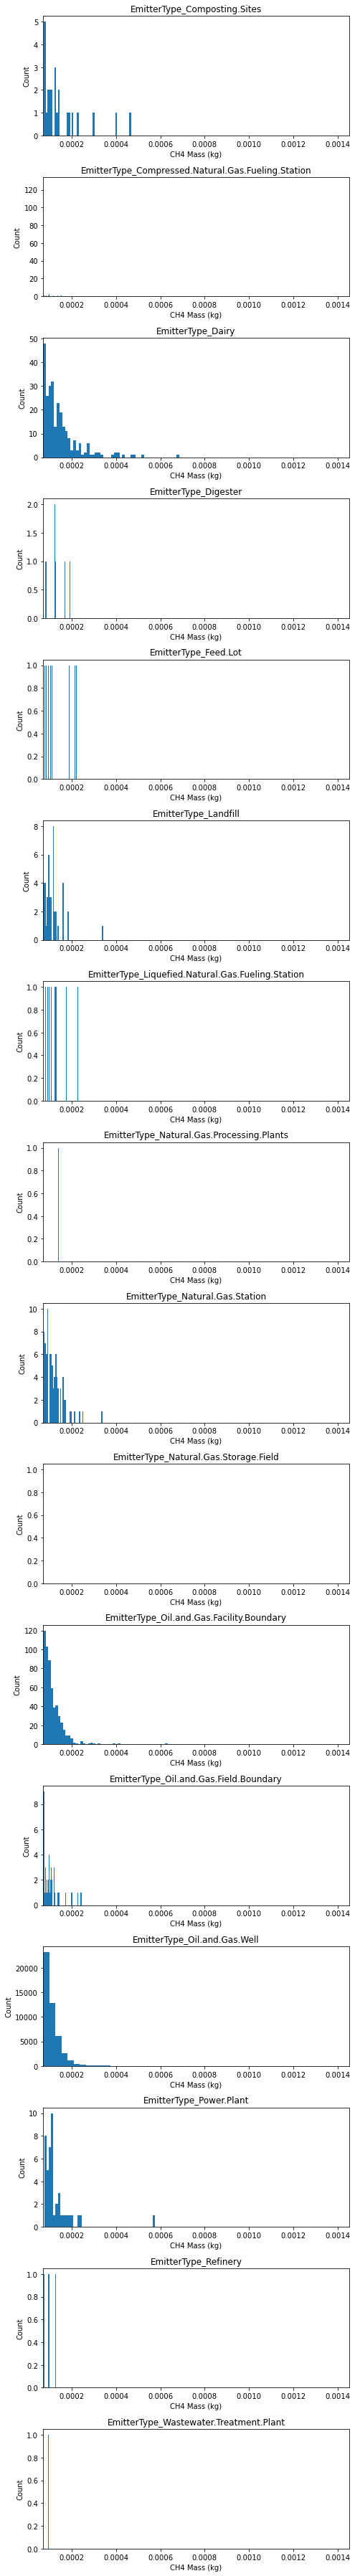

In [14]:
#Plot histogram of emissions level by each emitter type. 
fig, ax = plt.subplots(nrows = len(col_emitter_type), figsize = (7, 50))

for j, col in enumerate(col_emitter_type):
    data = gdf[['CH4_Mass_kg',col]]
    data = data.loc[data[col]==1]
    ax[j].hist(data['CH4_Mass_kg'], bins = 50)
    ax[j].set_xlim(gdf['CH4_Mass_kg'].min(),gdf['CH4_Mass_kg'].max())
    ax[j].set_title(str(col))
    ax[j].set_xlabel('CH4 Mass (kg)')
    ax[j].set_ylabel('Count')
plt.tight_layout()

#### Step 1: Train/Test Split

We'll first split our data into training (80%) and testing data (20%). 
The testing data will be used to evaluate how each our models perform.

We'll also drop one of the dummy columns from each of the sets of categorical variables. We'll drop `LULC_Shrub.Scrub` and `EmitterType_Wastewater.Treatment.Plant`

In [15]:
#We'll need to create a dataframe of our X variables (features), and our y variable
features = np.setdiff1d(list(gdf.columns),
                        ['Vista_ID', 'AVIRIS_CH4_median_date','AVIRIS_CH4_pxcount', 
                         'CH4_Mass_kg','LULC_majority_class','NearestNeighbor',
                         'AVIRIS_CH4_median_ppmm','NN_Type','aviris_month', 'aviris_year','geometry', 
                        'LULC_Shrub.Scrub', 'EmitterType_Wastewater.Treatment.Plant'] + vars_0 )

X = gdf[features]
Y = gdf['CH4_Mass_kg']

In [16]:
#Create train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 15)

Standardization is an important step in using Ridge and Lasso models to ensure that all features are put on the same scale, since these models penalize large coefficients. We'll also create a train/test split for our standardized features, with the same random_state to ensure we have the same split as above. 

In [17]:
#Standardize features
scalar = StandardScaler()
scalar.fit(X)
X_std = scalar.transform(X)

In [18]:
#Create train/test split with standardized features
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, Y, test_size = 0.2, random_state = 15)



We will use `X_train` and `y_train` to fit each of our models in the sections below, and `X_test` and `y_test` to compare between models once we have fit the parameters and hyperparameters of each model. 

#### Model 1: Ordinary Least Squares Regression
To begin, we'll use Ordinary Least Squares Linear regression.

We'll start by using `statsmodels` to fit the model on our training data, as this package provides more detailed statistical information about linear regression models. This will allow us to examine statistics such as R-squared and the P-value for each of our coefficients. 

We'll then run the model in `scikit learn` on both our testing and training data. 

In [19]:
#For statsmodels, we need to include a column of one's to X so that it can fit an intercept. We'll add this column to 
# our training data to run the model. 
X_stats = sm.add_constant(X_train)

#Fit OLS regression
sm_model = sm.OLS(y_train, X_stats)
results = sm_model.fit()
results_summary = results.summary()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CH4_Mass_kg   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     30.50
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          4.67e-275
Time:                        11:41:30   Log-Likelihood:             3.3266e+05
No. Observations:               38708   AIC:                        -6.652e+05
Df Residuals:                   38658   BIC:                        -6.648e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
EmitterType_Composting.Sites                        1.433e-05   2.45e-05      0.585      0.559   -3.37e-05    6.23e-05
EmitterType_Compressed.Natural.Gas.Fueling.Station -1.438e-05   2.29e-05     -0.628      0.530   -5.93e-05    3.05e-05
EmitterType_Dairy                                   2.031e-05   2.29e-05      0.887      0.375   -2.45e-05    6.52e-05
EmitterType_Digester                                9.749e-06   2.82e-05      0.346      0.730   -4.56e-05     6.5e-05
EmitterType_Feed.Lot                                1.381e-05   2.83e-05      0.489      0.625   -4.16e-05    6.92e-05
EmitterType_Landfill                               -9.774e-06   2.37e-05     -0.413      0.680   -5.62e-05    3.66e-05
EmitterType_Liquefied.Natural.Gas.Fueling.Station  -1.073e-06    2.9e-05     -0.037      0.970   -5.79e-05    5.57e-05
EmitterType_Natural.Gas.Processing.Plants           4.253e-06   3.17e-05      0.134      0.893    -5.8e-05    6.65e-05
EmitterType_Natural.Gas.Station                     -1.05e-05    2.3e-05     -0.456      0.649   -5.57e-05    3.47e-05
EmitterType_Natural.Gas.Storage.Field              -4.772e-05   3.89e-05     -1.228      0.219      -0.000    2.85e-05
EmitterType_Oil.and.Gas.Facility.Boundary          -4.932e-06   2.25e-05     -0.219      0.827   -4.91e-05    3.92e-05
EmitterType_Oil.and.Gas.Field.Boundary             -1.563e-05   2.38e-05     -0.658      0.511   -6.22e-05    3.09e-05
EmitterType_Oil.and.Gas.Well                       -8.973e-06   2.24e-05     -0.400      0.689   -5.29e-05     3.5e-05
EmitterType_Power.Plant                             4.891e-06   2.36e-05      0.208      0.836   -4.13e-05    5.11e-05
EmitterType_Refinery                               -1.378e-05   2.75e-05     -0.501      0.616   -6.77e-05    4.01e-05
LULC_Cultivated.Crops                               1.502e-05   5.35e-06      2.805      0.005    4.52e-06    2.55e-05
LULC_Dev..Low.Int                                  -2.004e-05    4.5e-05     -0.445      0.656      -0.000    6.82e-05
LULC_Dev..Med.Int                                   7.639e-07   4.47e-06      0.171      0.864      -8e-06    9.53e-06
LULC_Grassland                                      1.606e-05    5.3e-06      3.033      0.002    5.68e-06    2.64e-05
LULC_Mixed.Forest                                      0.0002   4.45e-05      4.013      0.000    9.14e-05       0.000
LULC_Open.Water                                     8.784e-07   4.64e-06      0.189      0.850   -8.22e-06    9.98e-06
LULC_barren_land_perc                                 -0.0012      0.000     -4.786      0.000      -0.002      -0.001
LULC_cultivated_crops_perc                            -0.0008      0.000     -3.583      0.000      -0.001  

Overall, our model had a $R^2$ value of 0.037, showing that our model doesn't seem to explain a large proportion of the variation in our response variable. However, AIC (a metric used to assess the quality of our model with a small value being better)could be improved by removing extraneous features via a model selection.

Looking at the t-statistic, where larger values are more significant, in conjunction with p values (should be at around 0), variables such as `OZONE`, `PM2.5`, `PM10`, `tropomi_o3_mean`, `tropomi_so2_mean`  `NN_Distance_m`, some of our LULC percent features, and `ng_pipelength_10000`/`50000`/`5000` seem to introduce the least error to the model.

Based off of these results we're skeptical about the significance of the following variables, since they include 0 within their 95% confidence interval: most of the `EmitterType` features,`LULC_Dev..*.Int`, `LULC_Open.Water`,  `ng_pipelength_1000`, `ng_pipelength_2`, and `tropomi_no2_mean`.

Let's compare these results with `scikit learn` to double check out work.

In [20]:
sk_model = linear_model.LinearRegression()
sk_fit = sk_model.fit(X_train,y_train)

print("Intercept:", sk_fit.intercept_)
# Coefficients
print("Coefficients:", sk_fit.coef_)

Intercept: 0.0010943481032018897
Coefficients: [ 1.43262489e-05 -1.43833748e-05  2.03119406e-05  9.74930073e-06
  1.38062426e-05 -9.77375927e-06 -1.07347178e-06  4.25326340e-06
 -1.04959534e-05 -4.77182843e-05 -4.93154599e-06 -1.56347331e-05
 -8.97282322e-06  4.89057837e-06 -1.37811481e-05  1.50162095e-05
 -2.00421416e-05  7.63930285e-07  1.60628573e-05  1.78555774e-04
  8.78391102e-07 -1.27273311e-03 -9.07707303e-04  1.20872619e-02
 -8.63200932e-04 -7.92802593e-04 -9.24405648e-04 -9.57148893e-04
 -1.01919865e-03 -9.35665245e-04 -9.15120015e-04 -9.17071315e-04
 -8.95585566e-04 -1.46619931e-03 -8.61121807e-04 -3.84803951e-14
  6.40698640e-04  7.67703999e-09  9.70805909e-08  4.44246770e-07
 -2.06863392e-07  3.36508137e-07  6.16568787e-12  2.29864250e-10
  2.14449475e-10 -3.73640909e-10 -2.67335532e-11 -1.43162206e-01
 -1.84662916e-05 -1.05765006e-04  1.07726349e-07]


The coefficients seem to match up. 

Now, we'll fit the model in `scikit learn`, and evaluate how the model performs on the testing data. We'll create a function that fits a linear regression model and returns the training and test MSE. 

In [21]:
#Create a function  that fits a linear regression model and returns the training and test MSE. 
def OLS(X_train, y_train, X_test, y_test):
    """ Fits an Ordinary Least Squares Linear regression on the training set of X and y,
    and finds the MSE of the training and test set. 
    Arguments:
        X_train: An ndarray containing the set of features used to train the model. 
        y_train: A list/array containing containing the set of response variable observations used to train the model.
        X_test: An ndarray containing the set of features used to test the model.
        y_test: A list/array containing the set of response variable observations used to test the model. 
    Returns:
        train_mse: the MSE for the training data
        test_mse: The MSE for the test data
        model_coef: The coefficients for the model
        """
    #Fit model
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, lm.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, lm.predict(X_test))
    
    return train_mse, test_mse

We can utilize our function to fit the model using Ordinary Least Squares Linear regression. 

In [22]:
ols_train_mse, ols_test_mse = OLS(X_train, y_train, X_test, y_test)
print("Training MSE: ", ols_train_mse)
print("Test MSE: ", ols_test_mse)

Training MSE:  2.007657950320016e-09
Test MSE:  1.9003416133366592e-09


It seems that our MSE is very small. However, this is also likely a factor of the scale of our response variable. Since our AIC is so large in this version of the OLS model, we'll vary the number of features we use to see what will improve the quality of our model.

We'll figure out what variables we may want to add first by sorting it on the t and p statistics.

In [23]:
# Take our results summary table and make it a dataframe
results_as_html = results_summary.tables[1].as_html()
results_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()

# Get absolute t value
results_summary_df['t_abs'] = np.absolute(results_summary_df['t'])

# Sort by large t and small p
results_summary_df = results_summary_df.sort_values(by=['t_abs', 'P>|t|'], ascending=[False,True])
results_summary_df

,index,coef,std err,t,P>|t|,[0.025,0.975],t_abs
40,PM10,-2.069000e-07,1.720000e-08,-12.010,0.000,-2.410000e-07,-1.730000e-07,12.010
45,ng_pipelength_5000,-3.736000e-10,3.550000e-11,-10.511,0.000,-4.430000e-10,-3.040000e-10,10.511
43,ng_pipelength_10000,2.299000e-10,2.280000e-11,10.098,0.000,1.850000e-10,2.740000e-10,10.098
49,tropomi_so2_mean,-1.000000e-04,1.330000e-05,-7.970,0.000,-0.000000e+00,-7.980000e-05,7.970
46,ng_pipelength_50000,-2.673000e-11,4.010000e-12,-6.666,0.000,-3.460000e-11,-1.890000e-11,6.666
33,LULC_pasture_hay_perc,-1.400000e-03,0.000000e+00,-5.757,0.000,-2.000000e-03,-1.000000e-03,5.757
48,tropomi_o3_mean,-1.847000e-05,3.220000e-06,-5.742,0.000,-2.480000e-05,-1.220000e-05,5.742
47,tropomi_no2_mean,-1.432000e-01,2.600000e-02,-5.580,0.000,-1.930000e-01,-9.300000e-02,5.580
39,OZONE,4.442000e-07,8.970000e-08,4.953,0.000,2.680000e-07,6.200000e-07,4.953
21,LULC_barren_land_perc,-1.200000e-03,0.000000e+00,-4.786,0.000,-2.000000e-03,-1.000000e-03,4.786


In [24]:
results_summary_df['coef_abs'] = np.absolute(results_summary_df['coef'])
results_summary_df.sort_values(by=['coef_abs'], ascending=[False]).head()

,index,coef,std err,t,P>|t|,[0.025,0.975],t_abs,coef_abs
47,tropomi_no2_mean,-0.1432,0.026,-5.580,0.000,-0.193,-0.093,5.580,0.1432
23,LULC_deciduous_forest_perc,0.0122,0.004,3.457,0.001,0.005,0.019,3.457,0.0122
33,LULC_pasture_hay_perc,-0.0014,0.000,-5.757,0.000,-0.002,-0.001,5.757,0.0014
21,LULC_barren_land_perc,-0.0012,0.000,-4.786,0.000,-0.002,-0.001,4.786,0.0012
35,LULC_total_perc,0.0010,0.000,4.370,0.000,0.001,0.001,4.370,0.0010


Above, we can see that the most important variable is `PM10`, which makes sense intuitively, as PM10 can be a pollutant that spans from high emitters. However, the coefficient is negative, indicating a negative correlation, which is not what we would expect. `tropomi_no2_mean` also has a negative correlation.

In terms of coefficient size, `LULC_deciduous_forest_perc` and `tropomi_no2_mean` have the largest values.

`LULC_deciduous_forest_perc` has a positive correlation, which is again not what we would expect. `LULC_emergent_herbaceous_wetlands_perc` has a negative correlation with a very small coefficient; here, the negative correlation does make sense, since we'd be less likely to see a methane-emitting facility located in areas that are majority wetlands (although wetlands are methane emitters, they are not anthropogenic sources, and thus are not included in our dataset). 

In [25]:
# Sort variables in order we think they're important (important ones first)
vars_to_add = results_summary_df['index']

And then we'll compute AIC and the loglikelihood function.

In [26]:
def computeAIC(fit_model,k):
    llf = fit_model.llf # get likelihood
    AIC = 2*k - 2*llf # calculate AIC
    
    return AIC

In [27]:
AIC_results = []
llf_results = []

for i, var in enumerate(vars_to_add):
    X_subset = X_train[vars_to_add[:i]]
    X2 = sm.add_constant(X_subset)
    sm_model = sm.OLS(y_train, X2)
    results = sm_model.fit()
    
    llf_results.append(results.llf)
    AIC_results.append(computeAIC(results,i))

We can visualize our results:

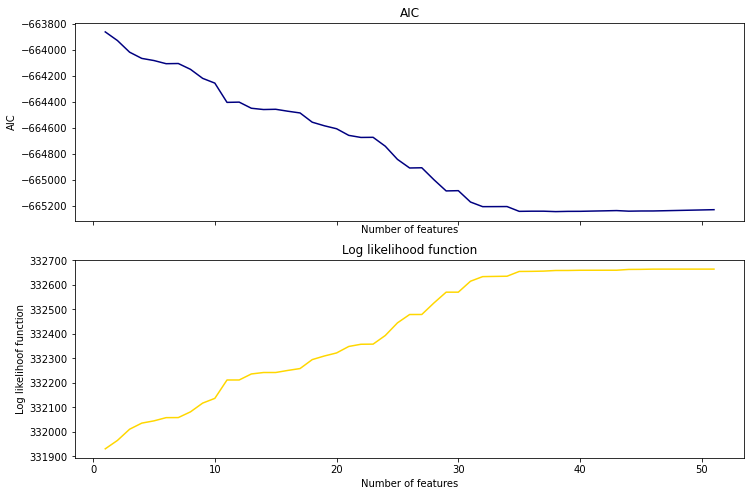

In [28]:
fig, (ax0,ax1) = plt.subplots(nrows=2, sharex=True, figsize = (12,8))

# AIC
ax0.plot(np.arange(1,len(vars_to_add)+1), AIC_results, color = 'navy')
ax0.set_xlabel('Number of features')
ax0.set_ylabel('AIC')
ax0.set_title('AIC')

# Log likelihood function
ax1.plot(np.arange(1,len(vars_to_add)+1), llf_results, color = 'gold')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Log likelihoof function')
ax1.set_title('Log likelihood function')

plt.show()

In [29]:
print("Best model based on AIC: ", np.argmin(AIC_results))
print("Best model based on LLF: ", np.argmax(llf_results))

Best model based on AIC:  37
Best model based on LLF:  50


If we choose our model based on a low AIC we would have the following variables:

In [30]:
print("Features for model  (based on AIC): \n", vars_to_add.iloc[:np.argmin(AIC_results)])

Features for model  (based on AIC): 
 40                                                 PM10
45                                   ng_pipelength_5000
43                                  ng_pipelength_10000
49                                     tropomi_so2_mean
46                                  ng_pipelength_50000
33                                LULC_pasture_hay_perc
48                                      tropomi_o3_mean
47                                     tropomi_no2_mean
39                                                OZONE
21                                LULC_barren_land_perc
35                                      LULC_total_perc
19                                    LULC_Mixed.Forest
28               LULC_emergent_herbaceous_wetlands_perc
41                                                PM2.5
27                       LULC_developed_open_space_perc
29                           LULC_evergreen_forest_perc
30                       LULC_grassland_herbaceous_perc
26        

We can re-run our model based on that to get our best quality model.

In [31]:
X_train[list(np.array(vars_to_add.iloc[:np.argmin(AIC_results)]))]

,PM10,ng_pipelength_5000,ng_pipelength_10000,tropomi_so2_mean,ng_pipelength_50000,LULC_pasture_hay_perc,tropomi_o3_mean,tropomi_no2_mean,OZONE,LULC_barren_land_perc,...,LULC_Cultivated.Crops,LULC_woody_wetlands_perc,ng_pipelength_2,weighted_cow_density,NO2,EmitterType_Natural.Gas.Storage.Field,EmitterType_Dairy,EmitterType_Oil.and.Gas.Field.Boundary,EmitterType_Compressed.Natural.Gas.Fueling.Station,EmitterType_Composting.Sites
10229,44.252134,108152.657178,140722.274852,0.384585,601778.142930,0.000036,2.685531,0.000024,62.341167,0.008532,...,0,0.000000,70554.851525,12.588844,6.955166,0,0,0,0,0
5341,50.315139,38259.249429,87642.485819,0.354530,456859.018159,0.000498,2.506767,0.000029,53.920130,0.010290,...,0,0.000000,7316.916325,16.253027,5.152299,0,0,0,0,0
40655,61.950983,154828.596419,203813.182168,0.351939,923810.878832,0.007057,2.697107,0.000033,65.343013,0.004250,...,0,0.010155,95561.852291,16.253027,11.056380,0,0,0,0,0
14223,92.058187,116268.676765,181552.833317,0.357810,885904.676751,0.006393,2.695420,0.000033,66.150266,0.003153,...,0,0.007766,73803.610603,16.253027,9.893962,0,0,0,0,0
42425,51.798751,134636.730230,209358.007358,0.312749,646393.477722,0.012380,2.697720,0.000064,51.037877,0.003562,...,0,0.000177,62140.599891,0.459964,20.620934,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35483,59.145893,132635.977068,181880.312966,0.350027,950809.009868,0.006425,2.504059,0.000033,60.239961,0.003672,...,0,0.003356,81461.235300,16.253027,6.493642,0,0,0,0,0
39296,40.747207,85861.210929,117742.294870,0.324675,288722.021730,0.024859,2.697917,0.000033,52.088547,0.004987,...,0,0.003727,51754.882630,1.005362,10.099150,0,0,0,0,0
2693,106.750935,145165.276042,209865.542067,0.359105,966801.514306,0.006400,2.695575,0.000034,66.150266,0.003625,...,0,0.004399,102308.905460,16.253027,9.893962,0,0,0,0,0
8076,89.686209,149717.918774,203852.640228,0.354328,929427.654450,0.006436,2.697020,0.000034,66.150266,0.003923,...,0,0.008986,91919.195187,16.253027,11.056380,0,0,0,0,0


In [32]:
ols_train_mse_2, ols_test_mse_2 = OLS(X_train[list(np.array(vars_to_add.iloc[:np.argmin(AIC_results)]))], y_train,
                                  X_test[list(np.array(vars_to_add.iloc[:np.argmin(AIC_results)]))], y_test)
print("Training MSE: ", ols_train_mse_2)
print("Test MSE: ", ols_test_mse_2)

Training MSE:  2.008239102476902e-09
Test MSE:  1.9011093777978814e-09


Compared with our prior train/test MSE from our model with all the features: 

In [33]:
#Calculate difference 
print('Training MSE Improvement:', ols_train_mse - ols_train_mse_2)
print('Test MSE Improvement:', ols_test_mse - ols_test_mse_2)

Training MSE Improvement: -5.811521568858204e-13
Test MSE Improvement: -7.677644612221733e-13


A very small improvement for our test MSE, but an improvement nonetheless!

#### Model 2: Ridge Regression
Since we have a large number of features in our model, we'll also want to try regularization methods; namely Ridge and Lasso Regression. These methods are computationally faster than subset selection, and can help reduce model variance associated with a large number of features.

We saw that in the OLS, our AIC was very large when we created the first version of our model including all of the features we had originally gathered. We can take advantage or Ridge here since it shrinks our coefficients toward zero, without ever fully eliminating them.

We'll begin by creating a function that fits the model, including tuning the hyperparameters, using K-fold cross validation. Considering the large size of our dataset, K-fold cross-validation will save a significant amount of computing time, as opposed to Leave One Out Cross Validation. In our case, we'll use 10 folds, following convention. 

In the case of Ridge and Lasso, the only hyperparameter we need to tune is our shrinkage penalty, which we'll denote here as `alpha`. 

To see how different alpha values perform, we'll also define a model to calculate the MSE for a range of alpha values during the KFold cross validation process on our training data. This way, we can visualize the MSEs for different alpha values to ensure we are choosing the optimal value. 

In [34]:
#First, we can define a model to get the MSE on our training data for a range of alpha values 
def model_mse_cv(Model, X_train, y_train, alphas, k):
    """
    Calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on X_train and 
    y_train for a range of values of alpha.
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data: Ridge, or Lasso
        X_train: the set of features used to fit the model
        y_train: the set of response variable observations
        alphas: a list of alpha values
        k: number of folds in k-fold cross-validation
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    #Initialize MSE array
    mses = np.full((k, len(alphas)), np.nan) 
    
    #Kfold split
    kf = KFold(n_splits = k, shuffle = True, random_state = 15) 
    
    fold = 0
    for train_i, val_i in kf.split(X_train):
        
        # get training and validation values
        X_f_train = X_train[train_i]
        X_f_val = X_train[val_i]
        y_f_train = np.array(y_train)[train_i]
        y_f_val = np.array(y_train)[val_i]
        
        for i in range(len(alphas)): 
            model = Model(alpha = alphas[i]) 

            model.fit(X_f_train, y_f_train) 
            
            y_pred = model.predict(X_f_val) 
            
            # save MSE for this fold and alpha value
            mses[fold, i] = mean_squared_error(y_pred, y_f_val)
        
        fold += 1
    
    # get average MSE for each alpha value across folds
    average_mses = np.zeros(len(alphas)) 
    for i in range(len(alphas)):
        average_mses[i] = np.mean(mses[:, i])
    
    return average_mses

We'll test this function on a range of alphas, and plot the MSE for each alpha value. 

In [35]:
#Define list of alpha values 
ridge_alphas = np.linspace(0.01, 200, 100)

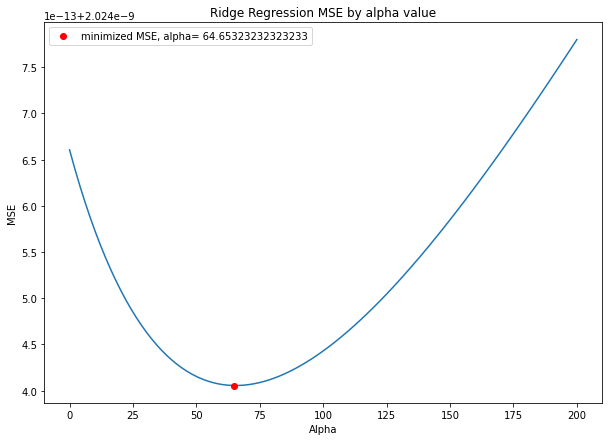

In [36]:
plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_ridge = model_mse_cv(Ridge, X_std_train, y_std_train, ridge_alphas, 10)
plt.plot(ridge_alphas, mse_ridge)
plt.plot(ridge_alphas[np.argmin(mse_ridge)], min(mse_ridge), 'ro', label = 'minimized MSE, alpha= ' + 
         str(ridge_alphas[np.argmin(mse_ridge)]))
plt.title("Ridge Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

From this graph, we can see that we reach our minimum alpha value at approximately 65. The graph has a clear minimum, with the MSE increasing substantially on either side of this minimum. 

Now, we can fit the model and see how it performs on our test data. 

In [37]:
#Define model for Ridge and Lasso Cross Validation
def fit_model_cv(Model, X_train, y_train, X_test, y_test, kf, alphas):
    """Fits a Ridge or Lasso model with K-fold cross-validation on the training set of X and y, 
    and finds the MSE of the training and test set. 
    Arguments:
        Model: The type of Model to use, RidgeCV or LassoCV.
        X_train: An ndarray containing the set of features used to train the model.
        y_train: A list/array containing the set of response variable observations used to train the model. 
        X_test: An ndarray containing the set of features used to test the model. 
        y_test: A list/array containing the set of response variable observations used to test the model. 
        kf: a KFold cross-validation selector object.
            [Note: This should have n_splits, shuffle, and random_state specified]. 
        alphas: a list of alpha values to test during the cross-validation process
    Returns:
        train_mse: the MSE for the training data
        test_mse: the MSE for the test data
        opt_alpha: the optimal alpha value"""
    
    #Fit model
    modelcv = Model(cv = kf, alphas = alphas)
    modelcv.fit(X_train, y_train)
    
    #Get optimal alpha value
    opt_alpha = modelcv.alpha_
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, modelcv.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, modelcv.predict(X_test))
    
    #Get coefficients
    coefficients = modelcv.coef_

    return train_mse, test_mse, opt_alpha, coefficients   

We'll define a KFold cross validation selector object, and use the list of alphas we defined above. 

In [38]:
#Define K-Fold cross-validation object
kf = KFold(n_splits = 10, shuffle = True, random_state = 15)

Now, we can utilize our function to find the optimal model using Ridge Regression. 

In [39]:
#Fit model
r_train_mse, r_test_mse, r_alpha, r_coef = fit_model_cv(RidgeCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                ridge_alphas)
print("Training MSE: ", r_train_mse)
print("Test MSE: ", r_test_mse)
print("Optimal Alpha Value: ", r_alpha)

Training MSE:  2.0078043240238427e-09
Test MSE:  1.9011630989587933e-09
Optimal Alpha Value:  62.633131313131315


We can compare how the test MSE for our ridge regression performs against both versions of our OLS model. 

In [40]:
#Compare test MSE between models
np.argmin([r_test_mse, ols_test_mse_2, ols_test_mse])

2

Between the Ridge, OLS with subset selection using AIC, and OLS with all of our features, the OLS with subset selection performed the best. 

We are also interested in seeing how our coefficients change with Ridge regression. 

In [41]:
#Create dataframe with coefficients
coef = pd.DataFrame({'Feature': X.columns, 'Index': np.arange(X.shape[1]), 
                    'Ridge': r_coef})

Text(0.5, 1.0, 'Ridge Coefficients')

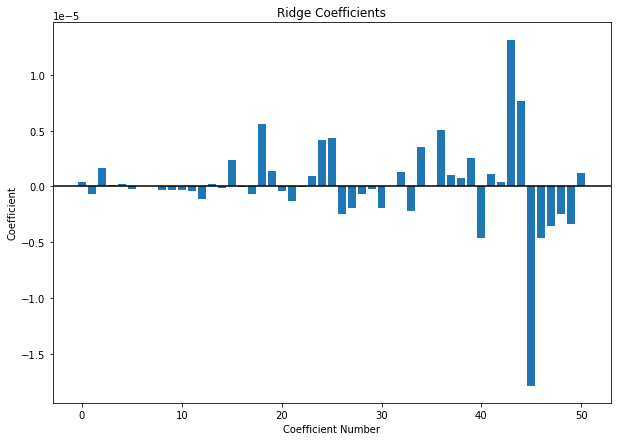

In [42]:
#Plot Coefficients
plt.figure(figsize = (10,7))
plt.bar(x = coef['Index'], height = coef['Ridge'])
plt.axhline(0, color = 'black')
plt.xlabel('Coefficient Number') 
plt.ylabel('Coefficient')
plt.title('Ridge Coefficients')

Let's look at which coefficients were the most significant for our Ridge regression. 

In [43]:
#Sort coefficients from largest in absolute value to smallest
coef.iloc[(-coef['Ridge'].abs()).argsort()]

,Feature,Index,Ridge
45,ng_pipelength_5000,45,-1.785150e-05
43,ng_pipelength_10000,43,1.316603e-05
44,ng_pipelength_2,44,7.675009e-06
18,LULC_Grassland,18,5.588295e-06
36,LULC_woody_wetlands_perc,36,5.030137e-06
40,PM10,40,-4.597893e-06
46,ng_pipelength_50000,46,-4.594258e-06
25,LULC_developed_low_int_perc,25,4.367891e-06
24,LULC_developed_high_int_perc,24,4.166004e-06
47,tropomi_no2_mean,47,-3.585839e-06


In line with our OLS model, `ng_pipeline_5000` was still our most significant feature. This time, however, `ng_pipelength_10000` was also significant, followed by `ng_pipelength_2` and `LULC_Grassland`. 

Interestingly, although Ridge does not typically push coefficients to zero, it did so in our case, likely because our coefficients were so small to begin with. `LULC_total_perc` was pushed to zero in our Ridge model. 

#### Model 3: Lasso Regression
Lasso, similar to Ridge, will shrink our coefficients; however, Lasso has the benefit of also performing subset selection, since some coefficients can be shrunk to zero. We'll try this model next, and see if we can achieve a better performance. 

Lasso has an advantage over Ridge when a small number of predictors that have large coefficients. So far, this doesn't seem to be the case with our model; however, we'll still want to try this model to compare performance. 

For our Lasso model, we'll use the same K-Fold cross validation. However, we'll define a new set of alpha values, since optimal Lasso alpha values tend to have a smaller range than Ridge alpha values. 

In [44]:
#Define lasso alpha values
lasso_alphas = np.linspace(1e-5, 10, 100)

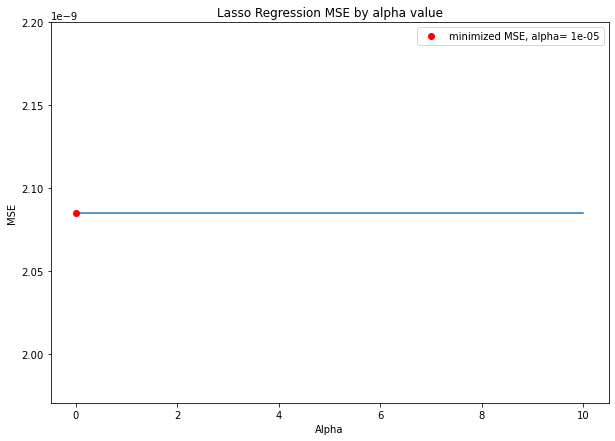

In [45]:
plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_lasso = model_mse_cv(Lasso, X_std_train, y_std_train, lasso_alphas, 10)
plt.plot(lasso_alphas, mse_lasso)
plt.plot(lasso_alphas[np.argmin(mse_lasso)], min(mse_lasso), 'ro', label = 'minimized MSE, alpha= ' + 
         str(lasso_alphas[np.argmin(mse_lasso)]))
plt.title("Lasso Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

The plot above gives us strange results. It seems that the MSE is the same regardless of the alpha value. This may be because Lasso shrinks all our coefficients to zero. Let's see if this is the case. 

In [46]:
#Fit model
l_train_mse, l_test_mse, l_alpha, l_coef = fit_model_cv(LassoCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                lasso_alphas)
print("Training MSE: ", l_train_mse)
print("Test MSE: ", l_test_mse)
print("Optimal Alpha Value: ", l_alpha)

Training MSE:  2.085267826741991e-09
Test MSE:  1.946743222028358e-09
Optimal Alpha Value:  10.0


In [47]:
l_coef

array([ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
        0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.])

The results show us that Lasso did indeed shrink all our coefficients to zero. We'll try an even smaller starting range of alpha values to see if this changes anything. Unfortunately, we can't start too small, or `scikitlearn` will give an error since the alpha values need to be greater than zero. We'll try one order of magnitude smaller. 

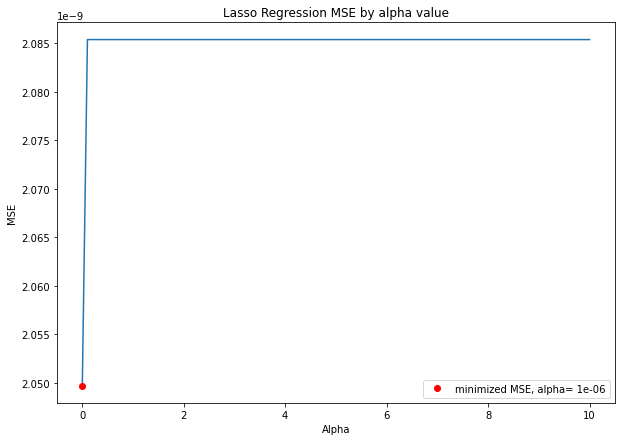

In [48]:
#Define lasso alpha values
lasso_alphas = np.linspace(1e-6, 10, 100)

plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_lasso = model_mse_cv(Lasso, X_std_train, y_std_train, lasso_alphas, 10)
plt.plot(lasso_alphas, mse_lasso)
plt.plot(lasso_alphas[np.argmin(mse_lasso)], min(mse_lasso), 'ro', label = 'minimized MSE, alpha= ' + 
         str(lasso_alphas[np.argmin(mse_lasso)]))
plt.title("Lasso Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

We managed to get a minimum MSE value with a very small Lasso value. Now we can run the model again to see the results. 

In [49]:
#Fit model
l_train_mse, l_test_mse, l_alpha, l_coef = fit_model_cv(LassoCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                lasso_alphas)
print("Training MSE: ", l_train_mse)
print("Test MSE: ", l_test_mse)
print("Optimal Alpha Value: ", l_alpha)

Training MSE:  2.045495161588075e-09
Test MSE:  1.9174961606598745e-09
Optimal Alpha Value:  1e-06


Let's take a look at the coeffiicients, and how they compare to Ridge.

In [50]:
coef['Lasso'] = l_coef

Text(0.5, 1.0, 'Lasso & Ridge Coefficients')

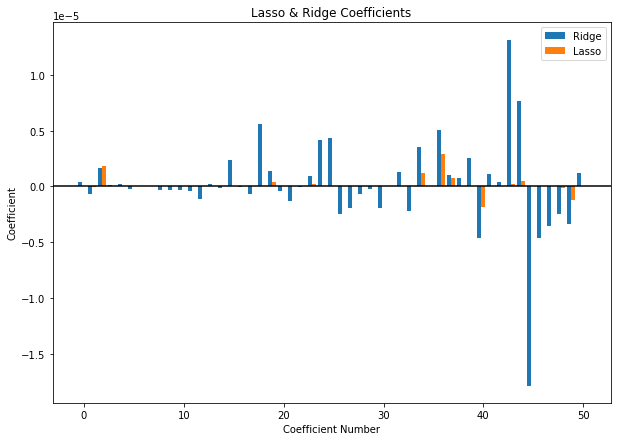

In [51]:
#Plot Coefficients
ind = np.arange(coef.shape[0])
width = 0.4
pos = np.array([ind-width, ind])

plt.figure(figsize = (10,7))

for i in np.arange(2):
    plt.bar(x = pos[i], height = coef.iloc[:, i + 2], width = width, label = coef.columns[i+2])
plt.legend()
plt.axhline(0, color = 'black')
plt.xlabel('Coefficient Number') 
plt.ylabel('Coefficient')
plt.title('Lasso & Ridge Coefficients')

Our Lasso model substantially reduced our number of features, leaving us with 7 features. Let's take a look at which feature coefficients are greater than 0. 

In [52]:
#subset by Lasso coefficients not equal to 0
lasso = coef[coef['Lasso'] != 0]

#Sort coefficients from largest in absolute value to smallest
lasso.iloc[(-lasso['Lasso'].abs()).argsort()]

,Feature,Index,Ridge,Lasso
36,LULC_woody_wetlands_perc,36,5.030137e-06,2.874571e-06
2,EmitterType_Dairy,2,1.655051e-06,1.842418e-06
40,PM10,40,-4.597893e-06,-1.819441e-06
34,LULC_shrub_scrub_perc,34,3.514198e-06,1.231833e-06
49,tropomi_so2_mean,49,-3.413048e-06,-1.211177e-06
37,NN_Distance_m,37,9.852038e-07,7.340166e-07
44,ng_pipelength_2,44,7.675009e-06,5.127089e-07
19,LULC_Mixed.Forest,19,1.357012e-06,3.943674e-07
43,ng_pipelength_10000,43,1.316603e-05,2.234318e-07
23,LULC_deciduous_forest_perc,23,9.347386e-07,2.217535e-07


Interestingly, for our Lasso model, the most significant feature was not the same as our Ridge and OLS models. Here, we have `LULC_woody_wetlands_perc`, `EmitterType_Dairy`, `PM10` as our three most significant features. 

The `tropomi_so2_mean` has consistently stayed in the top range of most significant features in all of our models. 

#### Model Comparison: OLS, Ridge, and Lasso

Below, we'll compare the test MSE for all our models. 

In [53]:
#Print OLS
print("OLS Test MSE: ", ols_test_mse)
print("OLS Test MSE feature selection using AIC: ", ols_test_mse_2)

#Print Ridge Values
print("Ridge Test MSE: ", r_test_mse)

#Print Lasso Values
print("Lasso Test MSE: ", l_test_mse)

OLS Test MSE:  1.9003416133366592e-09
OLS Test MSE feature selection using AIC:  1.9011093777978814e-09
Ridge Test MSE:  1.9011630989587933e-09
Lasso Test MSE:  1.9174961606598745e-09


In [54]:
#Find the index of the lowest MSE
all_mses = np.array([ols_test_mse, ols_test_mse_2, r_test_mse, l_test_mse])
all_models = np.array(['ols','ols selected','ridge','lasso'])
print("Lowest Test MSE:", np.min(all_mses))
print(all_models[np.argmin(all_mses)])

Lowest Test MSE: 1.9003416133366592e-09
ols


MSE looks pretty similar across the board.

With our predictions we can map our results from each model. If we had more time, we could have predicted methane at locations that aren't in the Vista dataset. But for this exercise let's just use the testing subset and see how those predictions differ from our response variable.

Let's first set up a function that gives us the predicted value for our model

In [55]:
def fit_model_predict(Model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    This function fits a model of type Model to the data in the training set of X and y,
    and returns the predicted values
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data - LinearRegression, Ridge, or Lasso
        X_train: the set of features used to train the model
        y_train: the set of response variable observations used to train the model
        X_test: the set of features used to test the model
        y_test: the set of response variable observations used to test the model
        alpha: the penalty parameter, to be used with Ridge and Lasso models only
    """    
    
    if Model == LinearRegression:
        model = Model()
    else:
        model = Model(alpha = alpha)
        
    model.fit(X_train, y_train)
    
    return model.predict(X_test)

And now let's use the above function to find the predicted values off of the test portion of our data

In [101]:
# Combine tested results from our three models and actual
compare_gdf = gdf.iloc[y_test.index][['Vista_ID', 'AVIRIS_CH4_median_date',
                                      'AVIRIS_CH4_pxcount', 'CH4_Mass_kg',
                                      'LULC_majority_class','geometry']].reset_index(drop=True)

# Predict OLS
compare_gdf['ols'] = fit_model_predict(LinearRegression, X_train, X_test, y_train, y_test)

# Predict Lasso
compare_gdf['ridge'] = fit_model_predict(Ridge, X_std_train, X_std_test, y_std_train, y_std_test, alpha = r_alpha)

# Predict lasso
compare_gdf['lasso'] = fit_model_predict(Lasso, X_std_train, X_std_test, y_std_train, y_std_test,alpha = l_alpha)

compare_gdf.head()

,Vista_ID,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,LULC_majority_class,geometry,ols,ridge,lasso
0,OGW104152,2017-09-06,484.551724,0.000094,Grassland,"MULTIPOLYGON (((93473.881 -287304.442, 93473.0...",0.000117,0.000117,0.000113
1,OGW076542,2017-10-10,1527.400000,0.000113,Grassland,"MULTIPOLYGON (((54687.648 -304351.272, 54686.8...",0.000123,0.000122,0.000113
2,OGW105331,2017-09-05,743.333333,0.000082,Grassland,"MULTIPOLYGON (((94342.214 -285248.417, 94341.3...",0.000112,0.000113,0.000114
3,OGW179513,2017-10-03,1190.666667,0.000108,Grassland,"MULTIPOLYGON (((100454.618 -280232.376, 100453...",0.000120,0.000121,0.000119
4,OGW135655,2017-09-02,1730.750000,0.000119,Grassland,"MULTIPOLYGON (((-34848.114 -198266.118, -34848...",0.000102,0.000102,0.000102


And now let's plot!

In [102]:
# find vmin and vmax for plotting colorbar extent
vmin = compare_gdf[['CH4_Mass_kg','ols','ridge','lasso']].min().min()
vmax = compare_gdf[['CH4_Mass_kg','ols','ridge','lasso']].max().max()
print(vmin,vmax)

5.267224432627037e-05 0.000933680408006129


In [103]:
# bring in california outline
ca_boundary = gpd.read_file('zip://data/ca-state-boundary.zip')
ca_boundary.to_crs(compare_gdf.crs, inplace=True)

In [104]:
def comparison_maps(vmin, vmax, xmin=None, xmax=None, ymin=None, ymax=None):
    '''
    Plots results from OLS, Ridge, Lasso with actual values
    If x lim and y lim values are specified they will be used 
    '''
    
    fig, ax = plt.subplots(2,2, figsize=(10,10))

    plt_titles = ['CH$_4$ measurement','OLS','Ridge','Lasso']

    ax_ravel = ax.ravel().tolist()

    for i, col in enumerate(['CH4_Mass_kg','ols','ridge','lasso']):

        # add california outline
        ca_boundary.plot(color='lightgrey', ax=ax_ravel[i])

        # Plot CH4 values
        plt_ch4 = compare_gdf[[col, 'geometry']].plot(column=col, ax=ax_ravel[i], vmin=vmin, vmax=vmax)

        # Remove tick marks and frame
        ax_ravel[i].set_frame_on(False)
        plt.setp(ax_ravel[i].get_xticklabels(), visible=False)
        plt.setp(ax_ravel[i].get_yticklabels(), visible=False)
        ax_ravel[i].set_xticks([])
        ax_ravel[i].set_yticks([])

        ax_ravel[i].set_title(plt_titles[i])
        
        if xmin!=None and xmax!=None and ymin!=None and ymax!=None:
            ax_ravel[i].set_xlim(xmin, xmax)
            ax_ravel[i].set_ylim(ymin,ymax)

    fig.tight_layout()
    # Note: since colorbar is manu`enter code here`ally added, tight_layout must be called before
    # rendering colorbar
    plt.colorbar(plt_ch4.collections[-1], ax=ax.ravel().tolist(), label='Ch$_4$ (kg)')
    plt.show()

In [105]:
comparison_maps(vmin=vmin, vmax=vmax)

ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 720x720 with 4 Axes>

Since it's pretty hard to tell from this zoomed our version, let's zoom into where we see a cluster of predictions.

In [106]:
comparison_maps(vmin=vmin, vmax=0.000225, xmin=30000,xmax=100000,ymin=-320000,ymax=-270000)

ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 720x720 with 4 Axes>

<font color='purple'><b> add explanation of differences if we see any once we see if we update the response variable</b>
    probably note clear that we have any clear reasons that are associated spatially with what we currently have.

Our **OLS model with feature selection using AIC** performed the best. 

The variation in most significant features throughout all of our models show us that there are **no features or groups of features that are consistently good predictors of methane emissions from the emitters included in our dataset**. Our `ng_pipelength_5000` came closest, as it had a coefficient that was significant in both our OLS and Ridge models. 

To improve our model in the future, we'll want to include additional features that can enhance our model performance. Since such a high percentage of our emitter types are oil and gas wells, we would likely want to identify features related to characteristics of these facilities that might be linked to the quantity of methane emissions. In the future, we may want to see if we could acquire enough data from Tropomi CH4 measurements to include it as a feature in our model. 

### Question 3: [Subsetting]

## Interpretation and Conclusions (20 points)
In this section you must relate your modeling and forecasting results to your original prediction question.  You must:
1. Address a resource allocation question.  What do the answers mean? What advice would you give a decision maker on the basis of your results?  How might they allocate their resources differently with the results of your model?  Why should the reader care about your results?
2. Discuss caveats and / or reasons your results might be flawed.  No model is perfect, and understanding a model's imperfections is extremely important for the purpose of knowing how to interpret your results.  Often, we know the model output is wrong but we can assign a direction for its bias.  This helps to understand whether or not your answers are conservative.  

Shoot for 500-1000 words for this section.